https://arxiv.org/pdf/1811.11212.pdf

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import torchvision
import torch.nn.functional as F

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [2]:
import util.plot as plot
import util.download

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')

import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 28
tfmnist = T.Compose([
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
#     T.Lambda(lambda x: x.repeat(3, 1, 1)),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,), std=(.5,)),
    
])

mnist_ds = torchvision.datasets.MNIST(DATA_DIR.joinpath('mnist'), download=True, transform=tfmnist)
mnist_dl = torch.utils.data.DataLoader(mnist_ds, batch_size=4, shuffle=True, num_workers=1)

Found 60000 images in dataset folder.


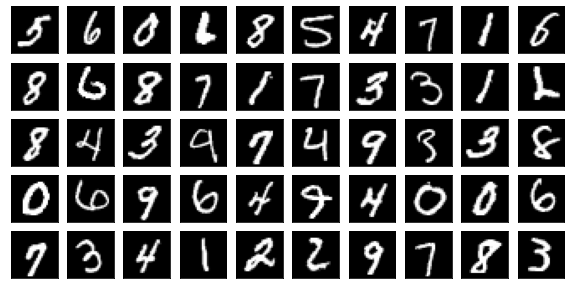

In [3]:
_ = plot.dataset_first_n_gray(mnist_ds, 50, figsize=(10,5), nrows=5)
print(f'Found {len(mnist_ds)} images in dataset folder.')

In [4]:
import ssgan as gan

print("### Image size")
x0, y0 = mnist_ds[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

print("#### Discriminator")
dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

print("### Discriminator output shape")
d0, d1 = dsc(x0)
print(d0.shape, d1.shape)

### Image size
torch.Size([1, 1, 28, 28])
#### Discriminator
Discriminator(
  (feature_extractor): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SpectralNorm(
      (module): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): SpectralNorm(
      (module): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (fc_gan): Linear(in_features=2304, out_features=1, bias=True)
  (fc_rot): Linear(in_

In [5]:
print("### Generator")
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

print("### Generator output shape")
z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

### Generator
Generator(
  (gen): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(128, 512, kernel_size=(3, 3), stride=(1, 1), bias=False)
    )
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): SpectralNorm(
      (module): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
    )
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): SpectralNorm(
      (module): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
### Generator output shape
torch.Size([1, 1, 28, 28])


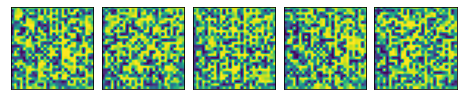

In [6]:
samples = gen.sample(5, with_grad=False)
_ = plot.tensors_as_images(samples.cpu())


In [7]:
from torch.utils.data import Dataset as Dataset
class SubsetDataset(torch.utils.data.Dataset):
    """
    A dataset that wraps another dataset, returning a subset from it.
    """
    def __init__(self, ds: Dataset, subset_len):
        super().__init__()
        self.ds = ds
        self.len = len(self.ds)
        self.subset_len = subset_len

    def __getitem__(self, index):
        idx = torch.randint(low=0,high=self.len, size=(1,))
        return self.ds[idx[0]]

    def __len__(self):
        return self.subset_len

In [11]:
import torch.optim as optim
from torch.utils.data import DataLoader

torch.manual_seed(999)

# Hyperparams
hp = dict(
        batch_size=32, z_dim=100, data_label=1, label_noise=0.2, weight_g=0.5, weight_d=1.0,
        discriminator_optimizer=dict(
            type='Adam', 
            lr=0.0002,
            weight_decay=0.02,
            betas=(0.5, 0.999)
        ),
        generator_optimizer=dict(
            type='Adam',  
            lr=0.0002,
            weight_decay=0.02,
            betas=(0.5, 0.999)
        ),
    )
    

ds = SubsetDataset(mnist_ds, subset_len=3200)
# Data
dl_train = DataLoader(ds, hp['batch_size'], shuffle=True)
im_size = mnist_ds[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# custom weights initialization called on netG and netD        
def weights_init(m):
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
gen.apply(weights_init)
dsc.apply(weights_init)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)

dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated, y_rot_logits):
    return gan.discriminator_loss_fn(y_data, y_generated, y_rot_logits, hp['data_label'], hp['batch_size'], hp['weight_d'])

def gen_loss_fn(y_generated, y_rot_logits):
    return gan.generator_loss_fn(y_generated, y_rot_logits, hp['data_label'], hp['batch_size'], hp['weight_g'])

# Training
checkpoint_file = 'checkpoints/ssgan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 32, 'z_dim': 100, 'data_label': 1, 'label_noise': 0.2, 'weight_g': 0.5, 'weight_d': 1.0, 'discriminator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'weight_decay': 0.02, 'betas': (0.5, 0.999)}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'weight_decay': 0.02, 'betas': (0.5, 0.999)}}


--- EPOCH 1/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.84it/s]
Discriminator loss: 1.2571567922830582
Generator loss:     1.8554372817277909


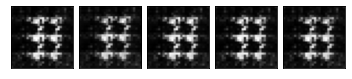

--- EPOCH 2/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s]
Discriminator loss: 0.9096945297718048
Generator loss:     1.5441804111003876


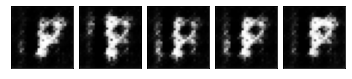

--- EPOCH 3/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.79it/s]
Discriminator loss: 0.8399544358253479
Generator loss:     1.235672309398651


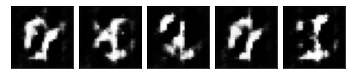

--- EPOCH 4/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.77it/s]
Discriminator loss: 0.9119716984033585
Generator loss:     1.132238854765892


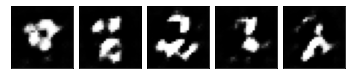

--- EPOCH 5/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.76it/s]
Discriminator loss: 0.933387251496315
Generator loss:     0.9883622604608536
Saved checkpoint.


C:\Users\Noam\Anaconda3\envs\noam-ai\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\Noam\Anaconda3\envs\noam-ai\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\Noam\Anaconda3\envs\noam-ai\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type SpectralNorm. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\Noam\Anaconda3\envs\noam-ai\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ConvTranspose2d. It won't be checked for correctness upon loading

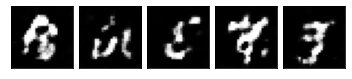

--- EPOCH 6/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.79it/s]
Discriminator loss: 0.9765161210298539
Generator loss:     0.9645162090659142


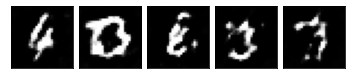

--- EPOCH 7/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s]
Discriminator loss: 0.9598105150461197
Generator loss:     0.926192472577095


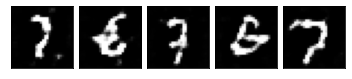

--- EPOCH 8/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.80it/s]
Discriminator loss: 0.9909298729896545
Generator loss:     0.9456952980160713


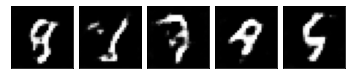

--- EPOCH 9/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s]
Discriminator loss: 0.9962992280721664
Generator loss:     0.9292133268713951


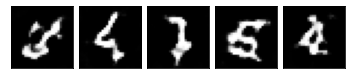

--- EPOCH 10/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.79it/s]
Discriminator loss: 0.9568616700172424
Generator loss:     0.9028721329569817
Saved checkpoint.


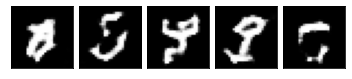

--- EPOCH 11/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.80it/s]
Discriminator loss: 0.983961021900177
Generator loss:     0.9088433802127838


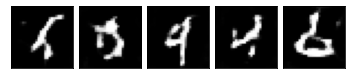

--- EPOCH 12/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.80it/s]
Discriminator loss: 0.9580771517753601
Generator loss:     0.9439343851804733


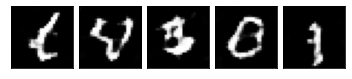

--- EPOCH 13/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.79it/s]
Discriminator loss: 0.9597306096553803
Generator loss:     0.913149351477623


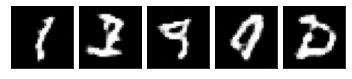

--- EPOCH 14/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s]
Discriminator loss: 0.9683919113874435
Generator loss:     0.9203298982977867


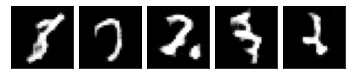

--- EPOCH 15/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.82it/s]
Discriminator loss: 0.9407057213783264
Generator loss:     0.9529593136906623
Saved checkpoint.


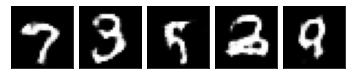

--- EPOCH 16/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.81it/s]
Discriminator loss: 0.9591408425569534
Generator loss:     0.9473308449983597


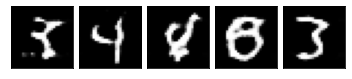

--- EPOCH 17/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.77it/s]
Discriminator loss: 0.9358835023641586
Generator loss:     0.9352819517254829


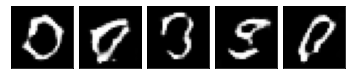

--- EPOCH 18/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.79it/s]
Discriminator loss: 0.9380573171377182
Generator loss:     0.9394022601842881


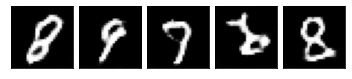

--- EPOCH 19/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.81it/s]
Discriminator loss: 0.9234455281496048
Generator loss:     0.9572281920909882


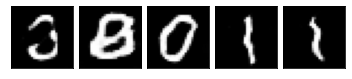

--- EPOCH 20/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.79it/s]
Discriminator loss: 0.9434358966350556
Generator loss:     0.952981673181057
Saved checkpoint.


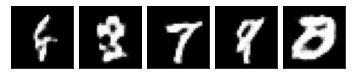

--- EPOCH 21/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.80it/s]
Discriminator loss: 0.916407476067543
Generator loss:     0.968223671913147


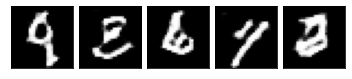

--- EPOCH 22/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.76it/s]
Discriminator loss: 0.8883180630207062
Generator loss:     1.0164785358309745


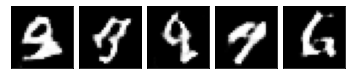

--- EPOCH 23/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s]
Discriminator loss: 0.9645643842220306
Generator loss:     0.9907658359408379


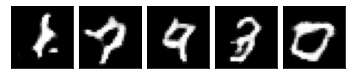

--- EPOCH 24/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.76it/s]
Discriminator loss: 0.935869288444519
Generator loss:     0.8982640033960343


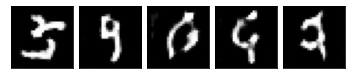

--- EPOCH 25/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.79it/s]
Discriminator loss: 0.9128029924631119
Generator loss:     0.9587632498145103
Saved checkpoint.


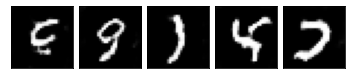

--- EPOCH 26/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.79it/s]
Discriminator loss: 0.9435982447862625
Generator loss:     0.9456743285059929


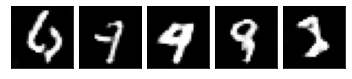

--- EPOCH 27/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.76it/s]
Discriminator loss: 0.9016486984491349
Generator loss:     0.997552450299263


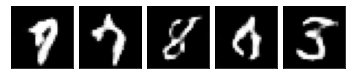

--- EPOCH 28/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s]
Discriminator loss: 0.9191985410451889
Generator loss:     0.9691077226400375


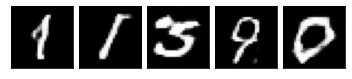

--- EPOCH 29/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.79it/s]
Discriminator loss: 0.9083838057518006
Generator loss:     0.98469298183918


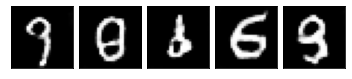

--- EPOCH 30/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.79it/s]
Discriminator loss: 1.00866958796978
Generator loss:     0.8468604889512062
Saved checkpoint.


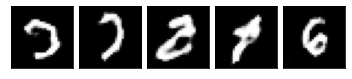

--- EPOCH 31/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.77it/s]
Discriminator loss: 0.9101348614692688
Generator loss:     0.9550897723436356


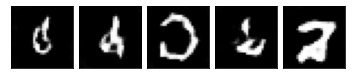

--- EPOCH 32/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.76it/s]
Discriminator loss: 0.9100537705421448
Generator loss:     0.9924925521016121


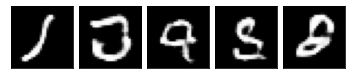

--- EPOCH 33/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.79it/s]
Discriminator loss: 0.8989679628610611
Generator loss:     0.9816206300258636


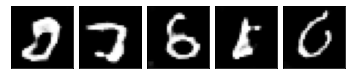

--- EPOCH 34/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s]
Discriminator loss: 0.8895730274915695
Generator loss:     0.9950152993202209


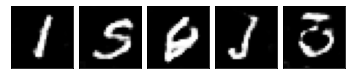

--- EPOCH 35/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.80it/s]
Discriminator loss: 0.9174102455377579
Generator loss:     0.9653665393590927
Saved checkpoint.


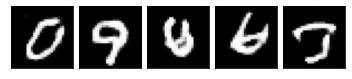

--- EPOCH 36/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.79it/s]
Discriminator loss: 0.9050508725643158
Generator loss:     0.9862174710631371


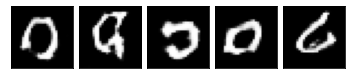

--- EPOCH 37/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s]
Discriminator loss: 0.8865739923715591
Generator loss:     0.9795264267921447


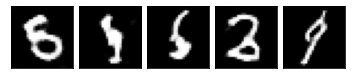

--- EPOCH 38/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s]
Discriminator loss: 0.8981177335977555
Generator loss:     0.9954577630758286


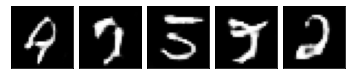

--- EPOCH 39/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.75it/s]
Discriminator loss: 0.8804816299676895
Generator loss:     1.0111101049184799


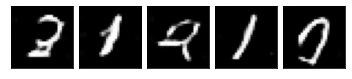

--- EPOCH 40/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.80it/s]
Discriminator loss: 0.9036100894212723
Generator loss:     0.9905048733949662
Saved checkpoint.


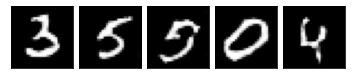

--- EPOCH 41/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.79it/s]
Discriminator loss: 0.8745716285705566
Generator loss:     1.014087145626545


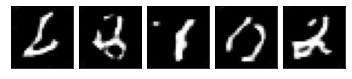

--- EPOCH 42/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.76it/s]
Discriminator loss: 0.9092247724533081
Generator loss:     0.9802468889951705


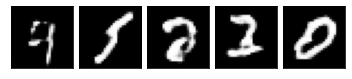

--- EPOCH 43/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.79it/s]
Discriminator loss: 0.8904578953981399
Generator loss:     0.9941781628131866


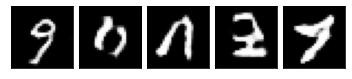

--- EPOCH 44/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.77it/s]
Discriminator loss: 0.9110135471820832
Generator loss:     0.9903405955433846


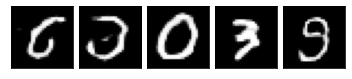

--- EPOCH 45/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.77it/s]
Discriminator loss: 0.8618158620595932
Generator loss:     1.0026295673847199
Saved checkpoint.


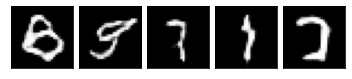

--- EPOCH 46/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.82it/s]
Discriminator loss: 0.9015030926465988
Generator loss:     1.0465587183833123


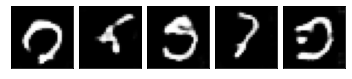

--- EPOCH 47/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.80it/s]
Discriminator loss: 0.9197539895772934
Generator loss:     0.899226016998291


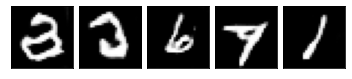

--- EPOCH 48/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.77it/s]
Discriminator loss: 0.8734144961833954
Generator loss:     0.9985230487585067


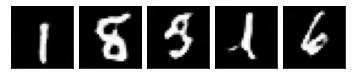

--- EPOCH 49/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.80it/s]
Discriminator loss: 0.8679674679040909
Generator loss:     1.0021689063310624


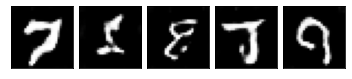

--- EPOCH 50/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.77it/s]
Discriminator loss: 0.8767603522539139
Generator loss:     1.0081489619612694
Saved checkpoint.


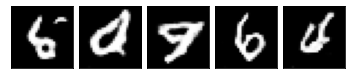

In [12]:
import IPython.display
import tqdm
from ssgan import train_batch, save_checkpoint

num_epochs = 50

# if os.path.isfile(f'{checkpoint_file_final}.pt'):
#     print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
#     num_epochs = 0
#     gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
#     checkpoint_file = checkpoint_file_final

try:
    dsc_avg_losses, gen_avg_losses = [], []
    for epoch_idx in range(num_epochs):
        # We'll accumulate batch losses and show an average once per epoch.
        dsc_losses, gen_losses = [], []
        print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

        with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
            for batch_idx, (x_data, _) in enumerate(dl_train):
                x_data = x_data.to(device)
                dsc_loss, gen_loss = train_batch(
                    dsc, gen,
                    dsc_loss_fn, gen_loss_fn,
                    dsc_optimizer, gen_optimizer,
                    x_data)
                dsc_losses.append(dsc_loss)
                gen_losses.append(gen_loss)
                pbar.update()

        dsc_avg_losses.append(np.mean(dsc_losses))
        gen_avg_losses.append(np.mean(gen_losses))
        print(f'Discriminator loss: {dsc_avg_losses[-1]}')
        print(f'Generator loss:     {gen_avg_losses[-1]}')
        
        if save_checkpoint(gen, dsc_avg_losses, gen_avg_losses, checkpoint_file):
            print(f'Saved checkpoint.')
            
        samples = gen.sample(5, with_grad=False)
        fig, _ = plot.tensors_as_gray_images(samples.cpu(), figsize=(6,2))
        IPython.display.display(fig)
        plt.close(fig)
except KeyboardInterrupt as e:
    print('\n *** Training interrupted by user')

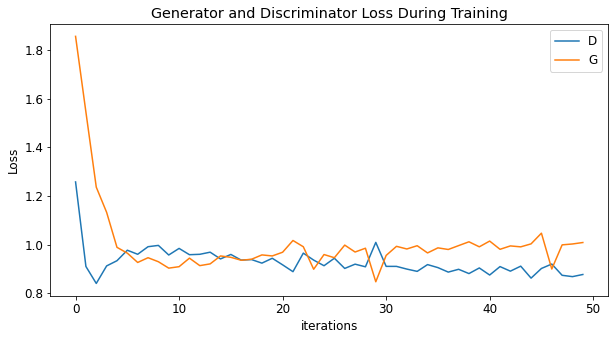

In [13]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(dsc_avg_losses,label="D")
plt.plot(gen_avg_losses,label="G")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [14]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)

*** Images Generated from best model:


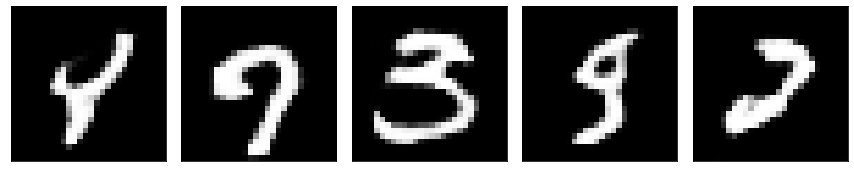

In [16]:
print('*** Images Generated from best model:')
samples  = gen.sample(n=5, with_grad=False)
fig, _ = plot.tensors_as_gray_images(samples.cpu(), nrows=1, figsize=(15,15))